In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
# Create the tools
 
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the ...'}]

In [3]:
llm_with_tools = llm.bind_tools(tools)
llm= llm_with_tools

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
graph_builder = StateGraph(State)

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [8]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [9]:
# from langgraph.prebuilt import ToolNode, tools_condition

tool_node = BasicToolNode(tools=[tool])

In [10]:
from typing import Literal

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [12]:
graph_builder.set_entry_point("chatbot")

In [11]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

In [13]:
graph_builder.add_edge("tools", "chatbot")

In [14]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)

In [15]:
graph = graph_builder.compile()

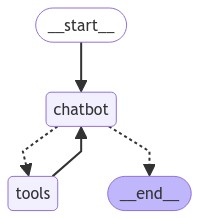

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://www.wsj.com/market-data/quotes/TSLA", "content": "The Wall Street Journal\nTesla Inc.\nNewsTesla Inc.TSLA\nKey Stock Data\nShort Interest (11/15/23)\nStock Money Flow\nN/A\nResearch & Ratings\nTesla Inc.(TSLA)\nPer-Share Earnings, Actuals and Estimates\nFinancials\nTesla Inc.(TSLA)\nCOMPETITORS (TSLA)\nPROFILE (TSLA)\nTesla, Inc. engages in the design, development, manufacture, and sale of fully electric vehicles and energy generation and storage systems. FactSet (a) does not make any express or implied warranties of any kind regarding the data, including, without limitation, any warranty of merchantability or fitness for a particular purpose or use; and (b) shall not be liable for any errors, incompleteness, interruption or delay, action taken in reliance on any data, or for any damages resulting therefrom. Change value during the period between open outcry settle and the commencement of the next day's trading is calculated as the difference be

In [19]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://www.theverge.com/2023/10/18/23923048/tesla-cybertruck-ev-pickup-delivery-date-november-30", "content": "Update October 18th, 2023 6:00PM ET: Added new production targets from Tesla earnings call and quotes from Musk.\nBritish monarchy rocked by bad Photoshop job\nHow to watch the 2024 Academy Awards\nThe perfect music streaming app does not exist\nLogitech\u2019s best gaming mouse just got better\nThe Super Mario Bros. Movie sequel is coming in 2026\nVerge Deals\n/ Sign up for Verge Deals to get deals on products we've tested sent to your inbox daily.\n Elon Musk says \u2018we dug our own grave with Cybertruck,\u2019 offers new delivery date\nElon Musk says \u2018we dug our own grave with Cybertruck,\u2019 offers new delivery date\nTesla\u2019s first pickup deliveries will take place November 30th at Gigafactory Texas, as Musk tries to temper expectations.\n Since its original announcement, other automakers have caught up, releasing their own el

In [21]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].pretty_print())

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_VgnPy9aUkKGPKFeUPjMGPC3q)
 Call ID: call_VgnPy9aUkKGPKFeUPjMGPC3q
  Args:
    query: Tesla news 2023
Assistant: None
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.theverge.com/2023/3/1/23620222/tesla-elon-musk-master-plan-cybertruck-investor-day", "content": "More from this stream Tesla Investor Day 2023: all the news and announcements from Elon Musk's next 'Master Plan' event. Green light. Mar 2, 2023, 1:48 PM UTC."}, {"url": "https://www.reuters.com/technology/gigacasting-20-tesla-reinvents-carmaking-with-quiet-breakthrough-2023-09-14/", "content": "Item 1 of 2 A general view of the Tesla gigafactory in Austin, Texas, U.S., February 28, 2023. REUTERS/Go Nakamura/File Photo ... the people said Tesla would need new bigger gigapresses with ..."}]
Assistant: None
=========

In [ ]:
user_input = "Remember my name?"
events = graph.stream(
    {"messages": [("user", user_input)]}, config_2, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()